I now realize hastags may be another interesting add on, like #nbapreseason vs #nbafinals. Clearly one of those is more interesting than the other, and perhaps that would lead to a different engagment rate. 


In an exploratory study I'll find the most common hashtags, and plot their engagement rates. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('husl')
%matplotlib inline

/Users/noahkasmanoff/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

In [3]:
def get_postscount(z,driver):
    """
    
    Obtains total number of posts to use a given hashtag, found in hashtag df. 
    
    Parameters
    ----------
    
    z : str
        The hashtag name, done via an apply statement. 
        
    driver : WebDriver
        Selenium webdriver object, used to naviagate to the URL of each account, and then grab the corresponding
        followers. 
        
    Returns 
    -------
    
    nposts : float
        The number of posts of that particular hashtag. 

    """
    from time import sleep
    from random import randint
    print("Hashtag: ", z)
    
    z = z.replace('#','')#.replace(' ','').replace('Â','').replace('å','').replace('â','') #clean unnecesary characters
   # print("Account: ", z)
    url = "https://www.instagram.com/explore/tags/" + z +"/?hl=en"
    driver.get(url)
    sleep(randint(1,3))
    try:
        nposts = driver.find_elements_by_class_name('g47SY')[0].text #total number of posts to use this hastag. 
    except:
        nposts = 1 #this was a type or something
        print(z , 'is a typo')
    print("# of posts with this hashtag = " , nposts)
    return nposts


def load_hashtags(instas):
    """
    
    Creates a dataset summarizing the instagram hashtags used in the post. 
    The columns used are a temporary list, and this line will be finalized once it is. 
    
    
    Parameters
    ----------
    
    instas : df
        Dataframe of the instagram posts, their associated information + output of engagements
        
        
    Returns
    -------
    
    
    hastag_df : df
    
        Dataframe of the hashtagss tagged in any or multiple posts. 
        
    """
    #use regular expression to obtain any time a name is used, find all
    import re
    instas['Description'] = instas['Description'].str.lower()

    posts = " ".join(instas['Description'].unique())
    hashtags = list( dict.fromkeys(re.findall('#[a-z_0-9]*',posts)) ) 
   # print("Total profiles: ", len(tagged_profiles))
    #iterate through these accounts, obtain info regarding how they are engaged. 
    d = []
    for hashtag in hashtags:
        posts_w_hashtag = instas.loc[instas['Description'].str.contains(hashtag)]
        max_eng = posts_w_hashtag.Engagements.max()
        tot_eng = posts_w_hashtag.Engagements.sum()
        n_posts = posts_w_hashtag.Engagements.count()
        min_eng = posts_w_hashtag.Engagements.min()
        avg_eng = posts_w_hashtag.Engagements.mean()
        var_eng = posts_w_hashtag.Engagements.std()
        d.append({'hashtags': hashtag, 'max_eng': max_eng,'tot_eng' : tot_eng, 
                 'n_posts' : n_posts, 'min_eng' : min_eng, 'avg_eng' : avg_eng,  'var_eng' : var_eng})

    hashtags_df = pd.DataFrame(d)
    #but we're not done, can also establish how popular these accounts are, doing it based on follower count. 
    from selenium import webdriver
    driver = webdriver.Chrome('/Users/noahkasmanoff/Desktop/chromedriver')

    hashtags_df['# of posts']  = hashtags_df['hashtags'].apply(lambda z: get_postscount(z,driver))
    driver.close()
    
    
    return hashtags_df

In [4]:
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.dropna(inplace=True)

In [3]:
hashtag_df = pd.read_csv('Business Analytics/hashtags.csv') #load_hashtags(instas)

In [6]:
hashtag_df['# of posts'] = hashtag_df['# of posts'].str.replace(',','').astype(float).fillna(1)

In [5]:
hashtag_df.drop('var_eng',axis=1,inplace=True)

In [6]:
hashtag_df.drop('tot_eng',axis=1,inplace=True)

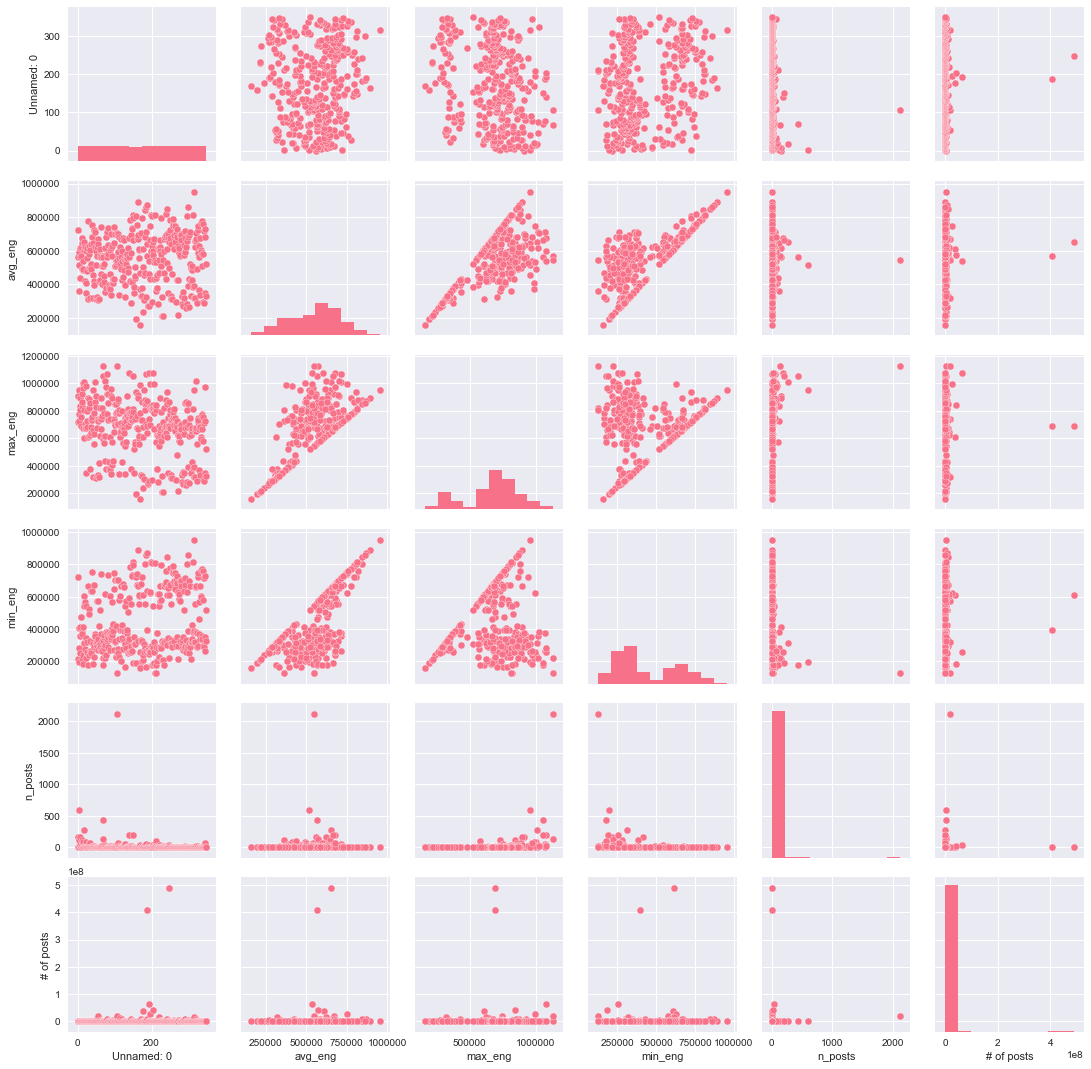

In [7]:
sns.pairplot(hashtag_df)

In [8]:
hashtag_df['# of posts'] = np.log10(hashtag_df['# of posts']+1)
hashtag_df['n_posts'] = np.log10(hashtag_df['n_posts']+1)

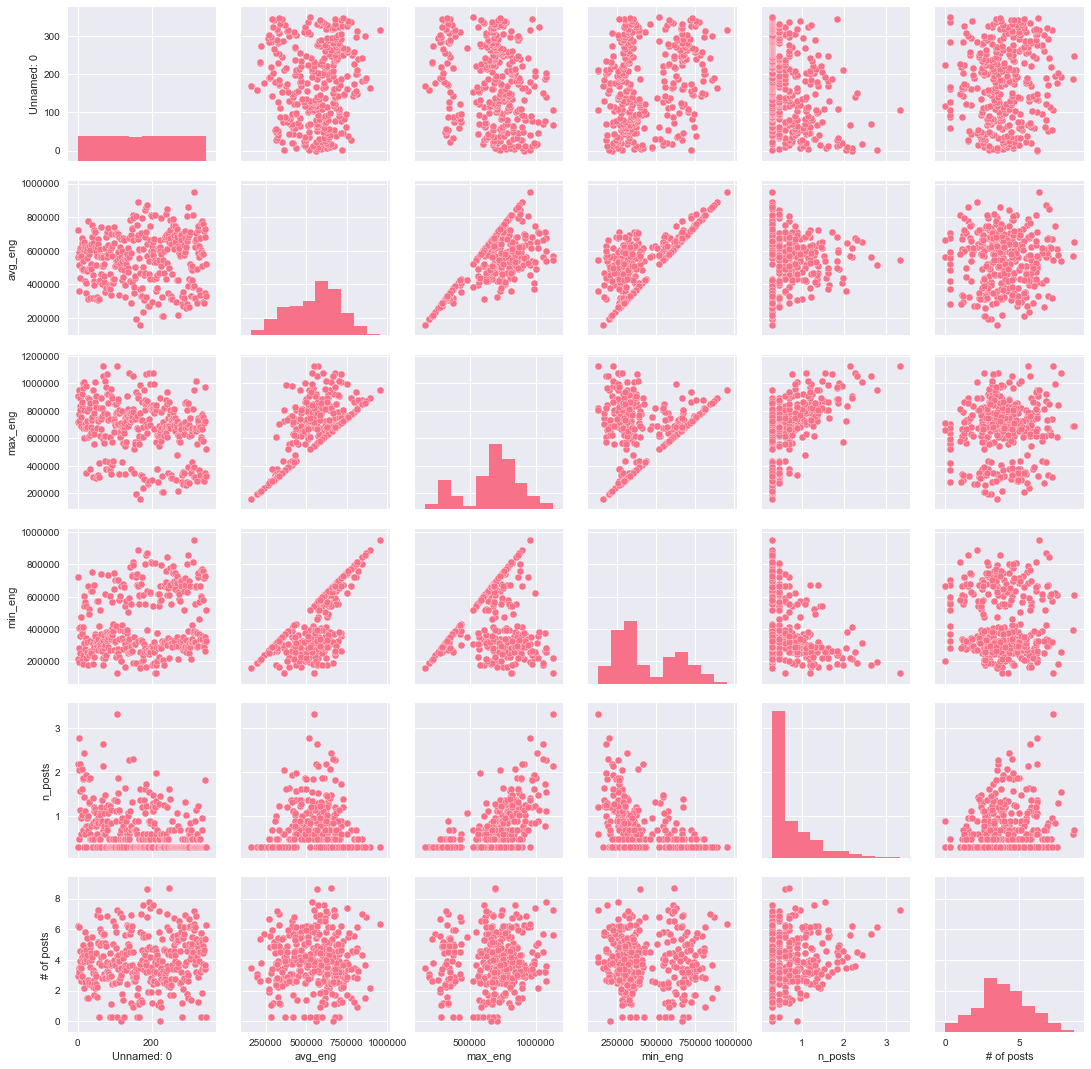

In [9]:
sns.pairplot(hashtag_df)

In [10]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = hashtag_df.drop('hashtags',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


In [11]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df[4].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

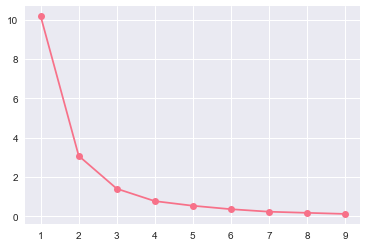

In [12]:
plt.plot(K,distortions,'o-')

In [13]:
kmeanModel = KMeans(n_clusters=4).fit(df[4].values.reshape(-1,1))

hashtag_df['tempCluster'] = kmeanModel.labels_

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


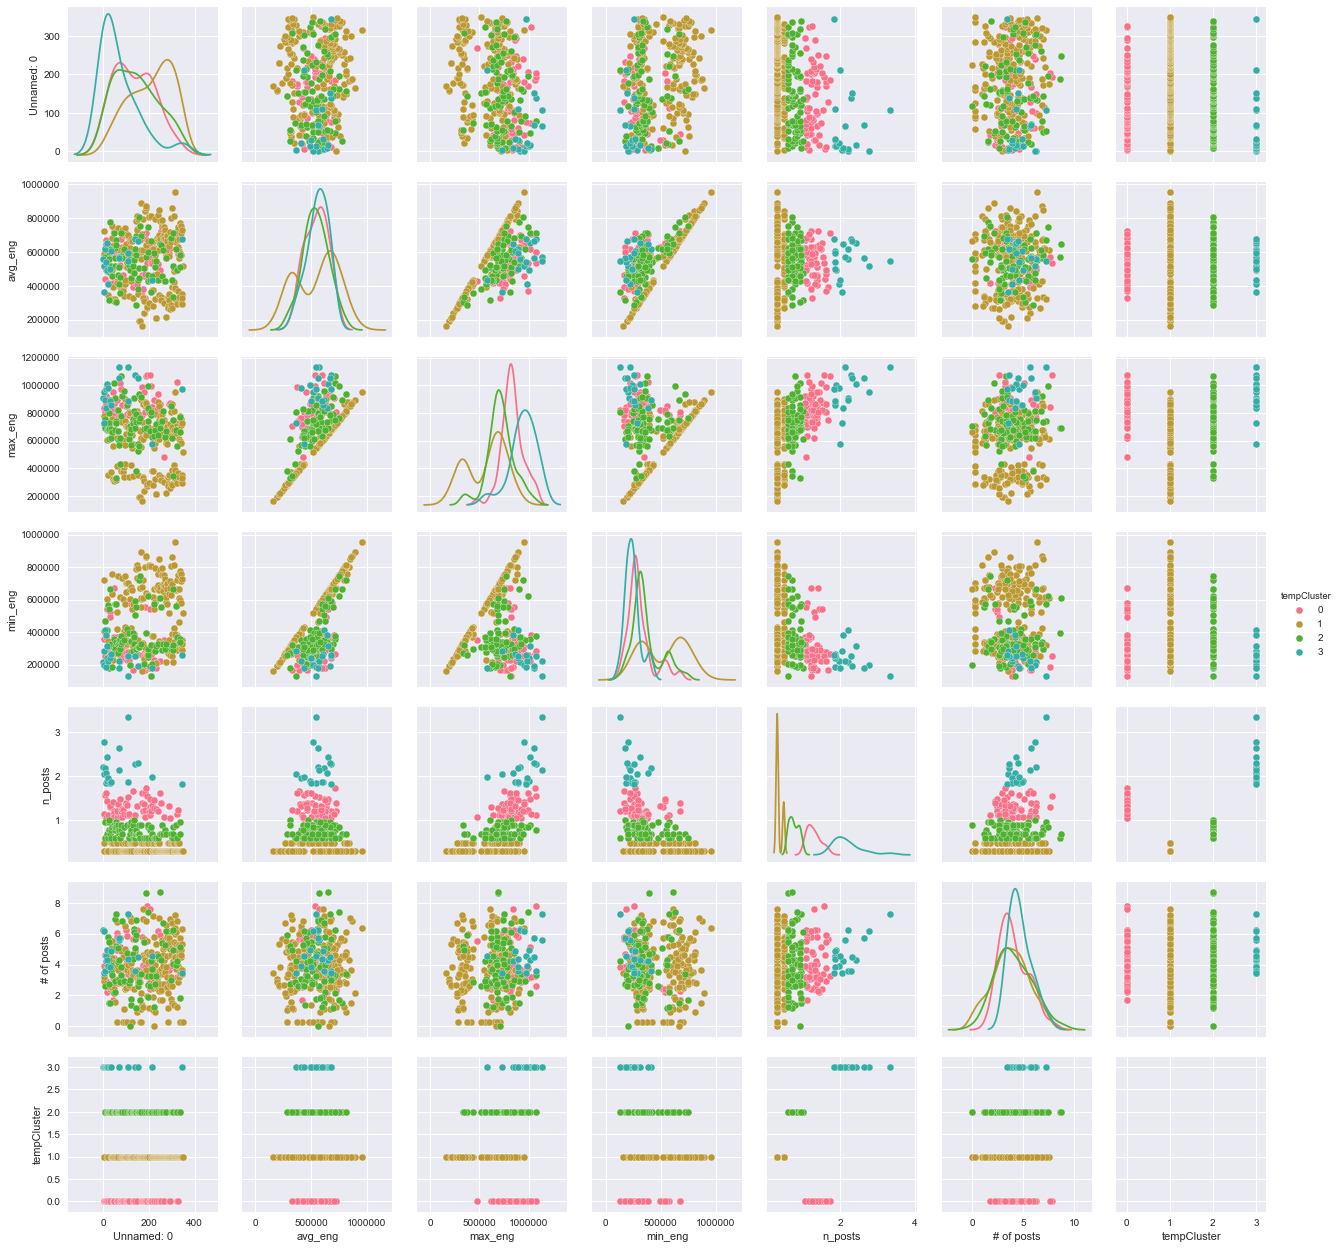

In [14]:
sns.pairplot(hashtag_df,hue='tempCluster',diag_kind='kde')

In [18]:
hashtag_df

,Unnamed: 0,avg_eng,hashtags,max_eng,min_eng,n_posts,# of posts,tempCluster
0,0,561512.662420,#nbafinals,909585,213824,2.198657,6.216565,3
1,1,722540.000000,#gatoradezero,722540,722540,0.301030,2.939519,1
2,2,517760.528814,#nbaplayoffs,954448,198217,2.771587,6.175109,3
3,3,363438.486486,#tripledoublealert,729066,281503,2.049218,3.461348,3
4,4,590180.000000,#powerbeatspro,775600,404760,0.477121,3.213252,1
5,5,563701.000000,#legendarymoments,833726,357280,1.146128,3.894925,0
6,6,618668.694805,#nbabreakdown,890873,412240,2.190332,3.550962,3
7,7,438375.567568,#nbaawards,807274,251554,1.579784,4.596861,0
8,8,624522.750000,#nbacombine,690297,471492,0.954243,3.502564,2
9,9,569828.666667,#nbaplaymakers,757785,471492,0.602060,2.641474,2


In [26]:
hashtags = hashtag_df[['hashtags','tempCluster']].copy()

In [27]:
hashtags = pd.get_dummies(hashtags,columns=['tempCluster'])

In [28]:
hashtags

,hashtags,tempCluster_0,tempCluster_1,tempCluster_2,tempCluster_3
0,#nbafinals,0,0,0,1
1,#gatoradezero,0,1,0,0
2,#nbaplayoffs,0,0,0,1
3,#tripledoublealert,0,0,0,1
4,#powerbeatspro,0,1,0,0
5,#legendarymoments,1,0,0,0
6,#nbabreakdown,0,0,0,1
7,#nbaawards,1,0,0,0
8,#nbacombine,0,0,1,0
9,#nbaplaymakers,0,0,1,0


In [35]:
def apply_clusters_to_training(z,hashtags):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    print(z)
    import re
    from numpy import zeros
    post_clusters = zeros(4)
    tags_in_z =  list( dict.fromkeys(re.findall('#[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    

    for tag_in_z in tags_in_z:
        try:
            post_clusters = post_clusters + hashtags[hashtags['hashtags'] == tag_in_z].values[0][1:] 
        except:
            pass
    return post_clusters

In [36]:
instas['tempClusters'] = instas['Description'].apply(lambda z: apply_clusters_to_training(z,hashtags))

The @raptors bench trio of @sergeibaka @normanpowell4 & @fredvanvleet combine for 48 in Game 4!
@kyle_lowry7 pulls from deep for the @raptors in the 4th on TNT!
@k_mid22 with some english on the @bucks dime!
Kawhi punches it home with the left on TNT!
@giannis_an34 goes baseline early to rock the rim on TNT!
Congrats to the 2018-19 NBA All-Rookie First Team, led by unanimous selections @lukadoncic & @traeyoung!
The @warriors locked in for four games to advance to the #NBAFinals presented by YouTube TV! #GatoradeZero
Will the @bucks take a commanding 3-1 lead... or will the @raptors even the ECF up 2-2??
TAP to SHOP the @warriors Western Conference Champions gear from @nbastore!
Hey @stephencurry30... that was the first time teammates had triple-doubles in the same #NBAPlayoffs game in @nbahistory!
@stephencurry30 (37/13/11) & @money23green (18/14/11) become the first teammates in #NBAPlayoffs history to record a triple-double in the same game!
The @warriors defeat @trailblazers 119-117

@stephencurry30 & the @warriors look to advance with a win (10pm/et ESPN)! #NBAPlayoffs
@trezz24 on both ends for the @laclippers! #NBABreakdown
...
??: @warriors/@laclippers G6
?: 10pm/et ??: ESPN
Heroes are among us. The new @jharden13 adidas x Marvel Iron Man Harden Vol. 3 just dropped @footlocker! #BecauseSneakers
Will the @warriors win & advance.. or will the @laclippers win & force a Game 7?
John Havlicek was a wonderful friend who represented the best of the NBA.  He described himself as a man of routine and discipline  a humble approach that produced extraordinary results, including eight NBA championships with the Boston @Celtics, 13 All-Star selections and some of the most iconic moments in league history.  A trusted teammate who prioritized winning, Johns passion and energy endeared him to basketball fans and made him a model for generations of NBA players.  We send our deepest sympathies to Johns wife, Beth, his son, Chris, and his daughter, Jill, as well as the entire 

?? @damianlillard puts up 14 of his 30 in the 4th for the @trailblazers! #NBAPlayoffs
The @trailblazers take 1-0 series lead with 104-99 victory at home! #NBAPlayoffs
@russwest44 secures his 9th career #NBAPlayoffs triple-double with 24/10/10. #TripleDoubleAlert
@3jmccollum splits the defense for the @trailblazers! #NBAPlayoffs #NBAonABC
?? THE GREEK FREAK takes on the #NBAPlayoffs! ??
@3jmccollum hesis into the lane for the @trailblazers floater! #NBAPlayoffs #NBAonABC
@damianlillard steps into the deep triple to open up scoring in Portland! #NBAPlayoffs #NBAonABC
The Easts top seed @bucks host the @detroitpistons 7:00pm/et @nbaontnt! #NBAPlayoffs
The @celtics take 1-0 series lead with 84-74 victory at home! #NBAPlayoffs
@gmb_chum12 hustles down to beat the buzzer for the @celtics! (??: @nbaontnt) #NBAPlayoffs
Thad Young hustles back for the @pacers denial! (??: @nbaontnt)
@kyrieirving with the early fadeaway for the @celtics! #NBAPlayoffs (??: @nbaontnt)
Sundays #NBAPlayoffs action

TypeError: expected string or bytes-like object

In [34]:
%debug

> /Users/noahkasmanoff/anaconda/lib/python3.6/re.py(222)findall()
    220 
    221     Empty matches are included in the result."""
--> 222     return _compile(pattern, flags).findall(string)
    223 
    224 def finditer(pattern, string, flags=0):

ipdb> z
*** NameError: name 'z' is not defined
ipdb> u
> <ipython-input-32-a517afa34007>(9)apply_clusters_to_training()
      7     from numpy import zeros
      8     post_clusters = zeros(4)
----> 9     tags_in_z =  list( dict.fromkeys(re.findall('#[a-z_0-9]*',z)) )
     10 
     11     if len(tags_in_z) == 0:

ipdb> z
nan
ipdb> exit


In [ ]:
clusters = pd.DataFrame(instas.tempClusters.tolist(), columns=['hashtags_nC1', 'hashtags_nC2','hashtags_nC3','hashtags_nC4'])

In [25]:
instas.merge(clusters,left_index=True,right_index=True)

NameError: name 'clusters' is not defined

And thats how you align cluster designations with predictive modelling. The same will be done for tagged profiles, and we can start exploring what predictive techniques work. 